# The problem 
An ant leaves its anthill in order to forage for food. It moves with the speed of 10cm per second, but it doesn't know where to go, therefore every second it moves randomly 10cm directly north, south, east or west with equal probability.

1. If the food is located on east-west lines 20cm to the north and 20cm to the south, as well as on north-south lines 20cm to the east and 20cm to the west from the anthill, how long will it take the ant to reach it on average?

2. What is the average time the ant will reach food if it is located only on a diagonal line passing through (10cm, 0cm) and (0cm, 10cm) points?

3. Can you write a program that comes up with an estimate of average time to find food for any closed boundary around the anthill? What would be the answer if food is located outside an defined by $((x – 2.5cm) / 30cm )^{2} + ( (y – 2.5cm) / 40cm )^{2} < 1$ in coordinate system where the anthill is located at (x = 0cm, y = 0cm)?



# Random Walk Background
## One Dimension
### Expectation and Variance
Consider the ant is moving along a straight line (e.g. the x axis). At each time step the ant either moves in the positive or negative x direction with equal probability.
Considering just the first timestep $t^{0}$ it is easy to see that the expectation of the position at $t^{1}$ is given by $E(x^{1}) = \sum_{i}^{1} x_i p_i = 0$, where $x_i \in \{-1, +1\}$ and $p_0 = p_1 = 0.5$. Similarly it can be shown that $var(x^{1}) = 1, \implies \sigma(x^{1}) = 1$.
Now generalising to the nth timestep we have that $E(x^{n}) = \sum_{j=0}^{n} E(x^{j}) = 0$. Using the definition of variance: $var(x) = E(x^{2}) - E(x)^2$ we can see that $var(x^{n}) = n \implies \sigma(x^{n}) = \sqrt{n}$.

In [3]:
# lets check our calculation with a monte carlo simulation

# import
from numpy.random import default_rng
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from math import sqrt
import numpy as np
from __future__ import annotations


# Let's create a base class that 1d and 2d ants can inherit from
class AntBase(metaclass=ABCMeta):
    def __init__(self):
        self.rng = default_rng()
        self.reset_coords()

    @abstractmethod
    def move(self) -> None:
        pass
    
    @abstractmethod
    def at_food(self) -> bool:
        pass

    @abstractmethod
    def reset_coords(self) -> None:
        pass

    def time_to_food(self) -> int:
        """
        Time how long ant takes to get to food
        """
        seconds = 0
        while not self.at_food():
            seconds += 1
            self.move()
        self.reset_coords()
        return seconds

# 1d ant inherits from base
class Ant1D(AntBase):
    def move(self) -> None:
        """
        Move the ant one random step +/- 10 cm along x axis
        """
        self.x += self.rng.choice((-10, +10))

    
    def at_food(self) -> bool:
        """
        Determine whether ant is at food or not
        """
        return abs(self.x) >= 20

    def reset_coords(self) -> None:
        """
        Reset ant's position to the origin
        """
        self.x = 0

    @staticmethod
    def sim(num_repeats: int, timesteps: list[int]) -> tuple[list[float]]:
        """ "
        Run num_repeats MC simulations for each time in timesteps
        returns: list of means, variances and standard deviations for each time in timesteps
        """
        ant = Ant1D()
        means = []
        variances = []
        standard_deviations = []
        for t in timesteps:
            positions = []
            for repeat in range(num_repeats):
                for i in range(t):
                    ant.move()
                positions.append(ant.x)
                ant.reset_coords()
            mean = sum(positions) / num_repeats
            means.append(mean)
            variance = sum((mean - i) ** 2 for i in positions) / num_repeats
            variances.append(variance)
            standard_deviations.append(sqrt(variance))
        return means, variances, standard_deviations

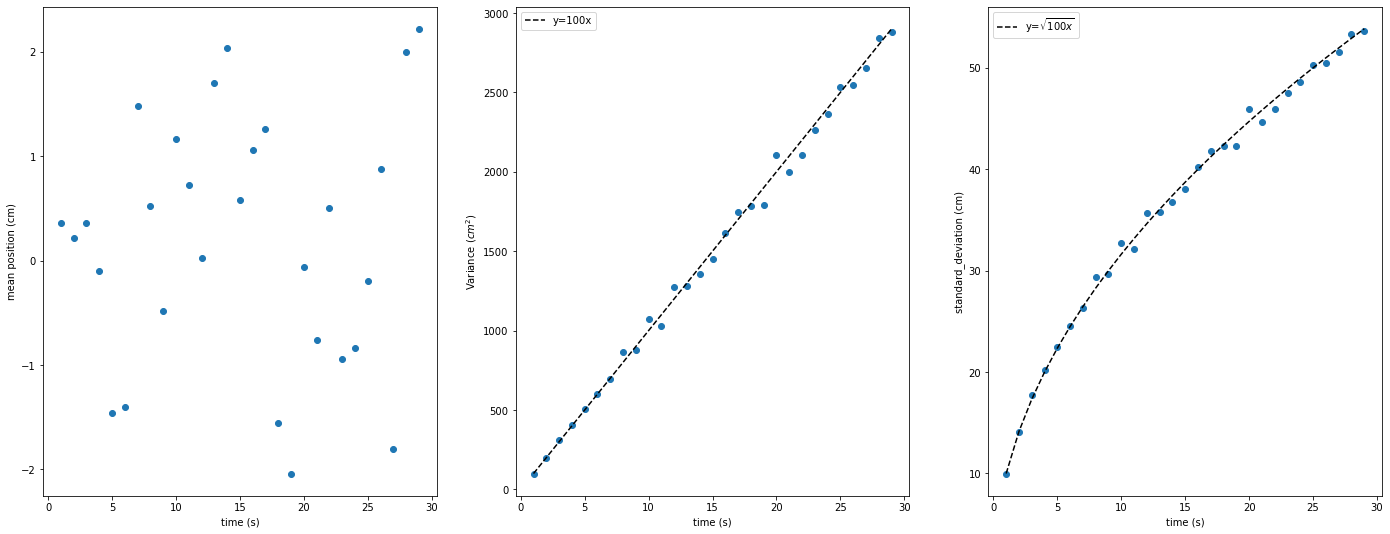

In [3]:
repeats = int(1e3)
timesteps = range(1, 30)
means, variances, standard_deviations = Ant1D.sim(repeats, timesteps)
# plot comparison of the sample statistics to the theoretical calculations we made in the md cell above
fig, ax = plt.subplots(1, 3, figsize=(24, 9))
ax[0].scatter(timesteps, means)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("mean position (cm)")
ax[1].scatter(timesteps, variances)
# Remember we are working in units of 10cm, so variance will be in units of 10^2 = 100cm^2
ax[1].plot(
    timesteps,
    [t * 100 for t in timesteps],
    linestyle="dashed",
    color="k",
    label="y=100x",
)
ax[1].legend()
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel(r"Variance ($cm^2$)")
ax[2].scatter(timesteps, standard_deviations)
# Again units of 10cm
ax[2].plot(
    timesteps,
    [10 * sqrt(t) for t in timesteps],
    label=r"y=$\sqrt{100x}$",
    linestyle="dashed",
    color="k",
)
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("standard_deviation (cm)")
ax[2].legend()
plt.show()

### The 1D problem
Now let's consider the one dimensional analogue to our two dimensional problem, what is the expectated number of timesteps for our ant to reach either +20cm or -20 cm? Clearly for reaching +/- 10cm this always happens on the first timestep. Let's consider the different permutations for timesteps and their associated probabilities. Clearly for n=1 the ant can never reach the food since they move at $10 ms^{-1}$. For the n=2 case we have 2 distinct permutations - moving in the same direction for the first 2 consecutive timesteps so $p(n=2) = 2 * \frac{1}{2^{2}} = \frac{1}{2}$. For the n=3 case we can see that we have zero probability. For the n=4 case we have 4 distinct permutations, moving initially in one direction and then either the opposite direction for the next 3 steps, or the opposite direction and then the initial direction for 2 consecutive steps. $p(n=4) = 4 * \frac{1}{2^{4}} = \frac{1}{4}$. We can rewrite this as $p(n=4) = \frac{1}{2} * p(n=2)$. Again for the n=5 case we can see that we have zero probability, in fact this is true for all odd n. For n=6 we can again see that there are 2 distinct branches for the first 2 moves (moving in one direction and then returning to the origin), before we arrive at the n=4 scenario: $p(n=6) = \frac{1}{2} * p(n=4) = \frac{1}{8}$. For even n we can generalise to $p(n) = \frac{1}{2^{\frac{n}{2}}}$. We can now write the expectation of n as $ E = \sum_{i=1}^{\infty} \frac{2i}{2^{i}} = 2\sum_{i=1}^{\infty} \frac{i}{2^{i}}$. Let's first check to see if this series converges using the ratio test: $|\lim_{n \to \infty} \frac{(n+1) \cdot 2^{n-1}}{n \cdot 2^{n}}| = |\lim_{n \to \infty} \frac{n+1}{2n}| = |\lim_{n \to \infty} \frac{1}{2} + \frac{1}{2n}| = \frac{1}{2} < 1$, therefore the series converges. To compute the sum, first explicitly write out a few terms: $S = \sum_{i=1}^{\infty} \frac{i}{2^{i}} = \frac{1}{2^1} + \frac{2}{2^2} +\frac{3}{2^3}+ \frac{4}{2^4} + ...$ $S = \sum_{i=1}^{\infty} \frac{1+0}{2^1} \frac{1+1}{2^2} + \frac{1+2}{2^3} + \frac{1+3}{2^4} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \sum_{i=1}^{\infty} \frac{i}{2^{n+1}} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \frac{1}{2} S$. We can simplify this to give an expression for S: $S = 2 \sum_{i=1}^{\infty} \frac{1}{2^{i}}$. Now we note the summation expression on the RHS is a simple geometric progression and totals 1. Hence we are left with $S = 2 \frac{\frac{1}{2}}{1-\frac{1}{2}} = 2 \implies E = 2S = 4$.
To compute the variance we again use $var(n) = E(n^{2}) - (E(n))^{2}$. $E(n^2) = 4 \sum_{i=1}^{\infty} \frac{i^2}{2^{i}} = 4 \cdot 6 = 24 \implies var(n) = 24 - 4^2 = 8 \implies \sigma(n) = \sqrt{8} = 2\sqrt{2}$

In [5]:
# Let's check with MC

num_repeats = int(1e3)
ant = Ant1D()

trials = np.array([ant.time_to_food() for _ in range(num_repeats)])

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=4.04
variance=8.4464
standard_deviation=2.9062690859588347


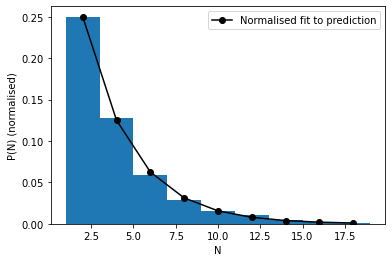

In [6]:
# check our calculation for P(n)

hist, bins, patches = plt.hist(trials, bins=np.arange(1, 20, 2), density=True)
centres = 0.5 * (bins[:-1] + bins[1:])
plt.plot(centres, [0.5 * 2 ** -(n/2) for n in centres], "-o", color="k", label="Normalised fit to prediction")
plt.legend()
plt.xlabel("N")
plt.ylabel("P(N) (normalised)")
plt.show()

### Final answer part 1: 4

### The 2D Problem

Here our ant is searching for food in 2 dimensions with food existing in a square around the origin. Again our ant moves at a speed of $10ms^{-1}$ but this time the ant can move up and down in the y direction as well as in the x direction. Having solved the first problem, we can frame our 2D problem as: What is E(n) such that |x| = 20 or |y| = 20? Here after 1 step we are at either (0, 10), (0, -10), (10, 0) or (-10, 0) with equal probality. Now P(n=2) is again simple to compute: 
$P(n=2) = 4 * \frac{1}{4^{2}} = \frac{1}{4}$. <br>
For the n=3 case we first consider the permutations of our ant finding itself in the 10x10 cm square centered at the origin. This is equal to the total possible paths after 2 steps ($4 * 4 = 16$) - the permutations that hit the 20x20 square boundary (previously calculated to be 4) - permutations for returning to the origin (also = 4 by symmetry) = 16 - 8 = 8. Note that for each n=2 permutation we are at the corners of our 10x10 square, hence there are 2 different way from each point to reach the 20x20 square boundary. 
Hence $P(n=3) = \frac{2*8}{4^3} = \frac{1}{4}$. <br>
For the n=4 case we consider the permutations in which the ant lies on the boundary of the 10x10 square after n=3 steps. First we note that our ant cannot lie on the corners after an odd number of steps so can the only points on the 10x10 square available are the points $(\pm 10, 0), (0, \pm 10)$. To return back to the same point as n=1 we have 3 permutations, to return to the points opposite the point at n=1 we have just 1 permutation, and the other 2 points we have 2 distinct permutations. Hence $P(n=4) = 4 * (3 + 1 + 2 + 2) * 1 * \frac{1}{4^4} = \frac{32}{256} = \frac{1}{8}$ <br>
It is now helpful to frame things more generally: As we have previously established after the first step we are at one of the points $\in \{(\pm10, 0), (0, \pm 10)\}$. On the next step we either hit the 20x20 square (n=2 case), or we hit the square after 2 more steps (n=3 case), or we are back at one of the points $\in \{(\pm10, 0), (0, \pm 10)\}$ after 2 steps. Let's consider the probabilities for even and odd step numbers separately: For odd n: $P(n) = (2 * 8 ^{\frac{n-1}{2}}) \frac{1}{4^n} = 2^1 * (2 ^{3(\frac{n-1}{2})}) * 2 ^{-2n} = 2 ^ {\frac{-n - 1}{2}} = \frac{1}{2^{\frac{n+1}{2}}}$. <br> 
For even n: $P(n) = 4 * 8 ^ {\frac{n-2}{2}} \frac{1}{4^n} = 2^2 * 2^{\frac{3(n-2)}{2}} * 2 ^ {-2n} = 2 ^ {\frac{-2 - n }{2}} = \frac{1}{2^{\frac{n+2}{2}}}$ <br>
Note that $P(2n) = P(2n-1),  \forall n > 1$ <br>
Hence $E = \sum_{i=1}^{\infty} 2i \frac{1}{2^{i+1}} + \sum_{i=1}^{\infty} (2i+1) \frac{1}{2^{i+1}}$ <br>
$\implies E = \sum_{i=1}^{\infty} (4i+1) \frac{1}{2^{i+1}} = 2 \sum_{i=1}^{\infty} \frac{i}{2^{i}} + \frac{1}{2} \sum_{i=1}^{\infty} \frac{1}{2^{i}}$ <br>
We have already calculated the sum on the LHS for the 1D case and found it is equal to 2, and the RHS sum is a simple geometric progression and totals 1. <br>
$\implies E = 2 * 2 + \frac{1}{2} * 1 = \frac{9}{2} =  4.5 $.

### Variance and standard deviation

We can now easily calculate the variance and standard deviation using the property $var(n) = E(n^2) - (E(n))^2$ <br>
$E(n^2) = \sum_{i=1}^{\infty} (2i)^2 \frac{1}{2^{i+1}} + \sum_{i=1}^{\infty} (2i+1)^2 \frac{1}{2^{i+1}} = 4\sum_{i=1}^{\infty} i^2 \frac{1}{2^{i}} + 2 \sum_{i=1}^{\infty} i \frac{1}{2^{i}} + \frac{1}{2} \sum_{i=1}^{\infty} \frac{1}{2^{i+1}} = 4 * 6 + 2 * 2 + \frac{1}{2} = \frac{57}{2}$ <br>
Hence $var(n) = \frac{57} {2} - (\frac{9}{2})^2 = \frac{33}{4} = 8.25 $, and the standard deviation $\sigma = \sqrt{\frac{33}{4}} \approx 2.87$

In [4]:
class Ant2D(AntBase):
    def move(self) -> None:
        choices = ((10, 0), (-10, 0), (0, 10), (0, -10))
        choice = self.rng.choice(choices)
        self.x += choice[0]
        self.y += choice[1]

    def at_food(self) -> bool:
        return abs(self.x) >= 20 or abs(self.y) >= 20

    def reset_coords(self) -> None:
        self.x = 0
        self.y = 0


ant = Ant2D()
num_repeats = int(5e3)
trials = np.array([ant.time_to_food() for _ in range(num_repeats)])

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=4.4922
variance=8.081139160000001
standard_deviation=2.8427344511930763


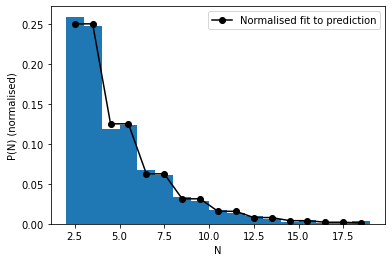

In [5]:
hist, bins, patches = plt.hist(trials, bins=np.arange(2, 20, 1), density=True)
centres = 0.5 * (bins[:-1] + bins[1:])
plt.plot(centres, np.power(2, -np.floor((bins[:-1] + 2)/2)), "-o", color="k", label="Normalised fit to prediction")
plt.legend()
plt.xlabel("N")
plt.ylabel("P(N) (normalised)")
plt.show()

### Part 2

Now we consider: What is the average time the ant will reach food if it is located only on a diagonal line passing through (10cm, 0cm) and (0cm, 10cm) points? 
First let's make a quick visualisation of the problem:

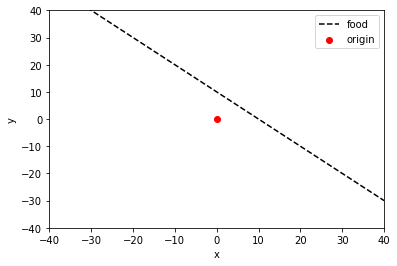

In [6]:
xvals = np.arange(-40, 50, 10)
yvals = 10 - xvals
plt.plot(xvals, yvals, linestyle="dashed", color="k", label="food")
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.scatter(0, 0, label="origin", color="r")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For any position (x, y) at time t, moving up or to the right moves 1 step closer to the food line. Moving down or to the left moves 1 step further away from the food line. <br> 
This enable to to project our 2d random walk into a 1D random walk with a single boundary point. Let's call the 1D projected axis r, starting at the origin r = 0, with the boundary point at r = 1. <br> 

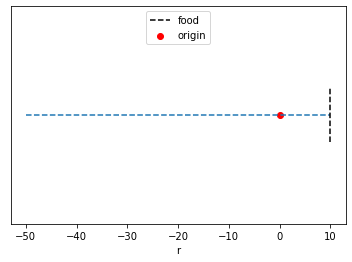

In [21]:
plt.hlines(0, -50, 10, linestyles='dashed')
plt.xlabel('r')
plt.vlines(10, -0.25, 0.25, color='k', linestyle='dashed', label='food')
plt.scatter(0, 0, label="origin", color="r")
plt.yticks([])
plt.ylim(-1, 1)
plt.legend(loc='upper center')
plt.show()

Then at each step we either move 1 step in the positive r direction, or 1 step in the negative r direction with equal probability. <br>
Now remind ourselves of the property of linearity of the expectation, that is if we denote the expected steps to reach r=+k as $E(X_1)$, by linearity $E(X_k) = \sum_{i=1}^k E(X_1)$. <br> We also note the translational invariance: $E(X_k)$ starting from 0 is equivelent to $E(X_{k-i})$ starting from i <br>
Now consider the scenario after the first step: Either we immediately hit the boundary with probability 0.5, or we arrive at -1 with probability 0.5. If we arrive at -1, the expected number of additional steps is then equivelent to $E(X_2)$.
<br>
Hence our expression becomes $E(X_1) = 1 + 0.5 \cdot 0 + 0.5 \cdot E(X_2) = 1 + 0.5 \cdot (E(X_1) + E(X_1) = 1 + E(X_1) \implies E(X_1) = \infty$ <br>
For more rigour we take $E(X_1) = 1 + \alpha E(X_1) \implies E(X_1) = \frac{1}{1-\alpha}$, and taking the limit $\lim_{\alpha \to 1} \frac{1}{1-\alpha} \implies E(X_1) = \infty $


In [33]:
class Ant2DLinearBoundary(Ant2D):
    def at_food(self) -> bool:
        return (self.x + self.y) >= 10
            
ant = Ant2DLinearBoundary()
num_repeats = np.arange(100, 1000, 100)
means = []
for n in num_repeats:
    trials = np.array([ant.time_to_food() for _ in range(int(n))])
    means.append(np.mean(trials))

### Final answer part 2: $\infty$

### Part 3

Now we have set up most of the hard work for the MC simulation to solve part 3, all that remains is to define a class with the appropriate at_food method

In [24]:
# Inherit all methods from Ant2D and redefine at_food 
class Ant2Dpart3(Ant2D):
    def at_food(self) -> bool:
        return ((self.x - 2.5) / 30) ** 2 + ((self.y - 2.5) / 40) ** 2 >= 1

In [25]:
ant = Ant2Dpart3()
num_repeats = int(1e5)
trials = np.array([ant.time_to_food() for _ in range(num_repeats)])

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=13.98048
variance=92.80637896959999
standard_deviation=9.633606747713962


### Final answer part 3: 14